In [1]:
%matplotlib inline
import sys
sys.path.insert(1, '../../../script/')

import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno

from collections import defaultdict
from scipy.stats.stats import pearsonr
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from collections import defaultdict
from scipy.stats.stats import pearsonr



import cleaning as cl
%load_ext autoreload
%autoreload 2

In [51]:
df = pd.read_csv('../../data/training.csv') 

In [52]:
df = df.dropna(subset=['MMRAcquisitionAuctionAveragePrice'])

In [53]:
df['MMRAcquisitionAuctionAveragePrice'].isnull().value_counts()

False    58373
Name: MMRAcquisitionAuctionAveragePrice, dtype: int64

In [54]:
def fill_nall_with_mode(x):
    return x.fillna(x.mode(dropna=False)[0])

def fill_nall_with_median(x):
    return x.fillna(x.median())

def cleaning(df):
    ###########################################
    #Fill missing values
    ###########################################

    #For WheelTypeID we have applied a recursively groupby substitution
    df['WheelTypeID'] = df.groupby(['Make','Model','SubModel'])['WheelTypeID'].apply(fill_nall_with_mode)
    df['WheelTypeID'] = df.groupby(['Make', 'Model'])['WheelTypeID'].apply(fill_nall_with_mode)
    df['WheelTypeID'] = df.groupby(['Make'])['WheelTypeID'].apply(fill_nall_with_mode)
    #df['WheelType'] = df.groupby(['Make','Model','SubModel'])['WheelType'].apply(fill_nall_with_mode)
    df['Color'] = df['Color'].fillna(df['Color'].mode()[0])
    df['Transmission'] = df['Transmission'].fillna(df['Transmission'].mode()[0])
    df['Nationality'] = df['Nationality'].fillna('AMERICAN')

    
    ###########################################
    #Typo correction
    ###########################################
    df.iat[6895, 11]    =   'MANUAL'
    df.iat[42627, 6]    =   'SCION'

    #a = df[(df['Nationality']=='TOP LINE ASIAN') | (df['Nationality']=='OTHER ASIAN')].index
    #for x in a:
    #    df['Nationality'].values[x] = 'ASIAN'
    
    # WheelTypeID 0.0 correction
    df.iat[3897, 12]    =   1.0
    df.iat[23432, 12]   =   1.0
    df.iat[23831, 12]   =   2.0
    df.iat[45666, 12]   =   1.0

    # submodel la mode sui group by 
    # Praticamente è la mode sui group by (più o meno specifici)

    df.iat[28961, 9] = '4D SEDAN SE1'
    df.iat[35224, 9] = '4D SEDAN SXT FFV'
    df.iat[48641, 9] = '4D SEDAN SXT FFV'
    df.iat[28280, 9] = 'PASSENGER 3.9L SE'
    df.iat[33225, 9] = '4D SUV 4.6L'
    df.iat[50661, 9] = 'REG CAB 2.2L FFV'
    df.iat[23019, 9] = '4D SEDAN'

    # size la mode sui group by
    df.iat[18532, 16] = 'MEDIUM SUV'
    df.iat[20016, 16] = 'SMALL SUV'
    df.iat[35157, 16] = 'SMALL SUV'
    df.iat[15769, 16] = 'MEDIUM SUV'

    ###########################################
    #Dropped features
    ###########################################
    del df['PRIMEUNIT']
    del df['AUCGUART']
    del df['RefId']
    del df['VNZIP1']
    del df['Auction']
    del df['IsOnlineSale']
    del df['SubModel']
    del df['VehYear']
    del df['PurchDate']
    del df['Trim']
    del df['TopThreeAmericanName']
    del df['WheelType']
    del df['BYRNO']
    
    ###########################################
    #Row deletion outliers
    ###########################################

    #Continuos features
    features = ['VehOdo',
                'MMRAcquisitionAuctionAveragePrice',
                'MMRAcquisitionAuctionCleanPrice', 
                'MMRAcquisitionRetailAveragePrice',
                'MMRAcquisitonRetailCleanPrice',
                'MMRCurrentAuctionAveragePrice',
                'MMRCurrentAuctionCleanPrice',
                'MMRCurrentRetailAveragePrice',
                'MMRCurrentRetailCleanPrice',
                'VehBCost',
                'WarrantyCost',
                'VehicleAge']
    
    for feature in features:
        for isBadBuy in [0,1]:
            q1 = df[(df.IsBadBuy == isBadBuy)][feature].quantile(0.25)
            q3 = df[(df.IsBadBuy == isBadBuy)][feature].quantile(0.75)
            iqr = q3 - q1
            qlow = q1 - 1.5*iqr
            qhigh = q3 + 1.5*iqr

            df.drop(df[(df.IsBadBuy == isBadBuy) & (df[feature] <= qlow)].index, inplace=True)
            df.drop(df[(df.IsBadBuy == isBadBuy) & (df[feature] >= qhigh)].index, inplace=True)

    features = [    ['MMRAcquisitionAuctionAveragePrice','MMRCurrentAuctionAveragePrice'],
                    ['MMRAcquisitionAuctionCleanPrice','MMRCurrentAuctionCleanPrice'],
                    ['MMRAcquisitionRetailAveragePrice','MMRCurrentRetailAveragePrice'],
                    ['MMRAcquisitonRetailCleanPrice','MMRCurrentRetailCleanPrice'],
                    ['MMRCurrentAuctionAveragePrice','MMRAcquisitionAuctionAveragePrice'],
                    ['MMRCurrentAuctionCleanPrice','MMRAcquisitionAuctionAveragePrice'],
                    ['MMRCurrentRetailAveragePrice','MMRAcquisitionRetailAveragePrice'],
                    ['MMRCurrentRetailCleanPrice','MMRAcquisitionRetailAveragePrice']
                ]
    for feature in features:
        for value in [0.0, 1.0]:
            df.drop(df[df[feature[0]]== value].index, inplace=True)

In [55]:
cleaning(df)

In [56]:
df[df['MMRAcquisitionAuctionAveragePrice']== 0]

,IsBadBuy,VehicleAge,Make,Model,Color,Transmission,WheelTypeID,VehOdo,Nationality,Size,...,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VNST,VehBCost,WarrantyCost


In [57]:
X = df[["VehBCost", "WarrantyCost", "MMRAcquisitionAuctionAveragePrice"]]

#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

# k = 2

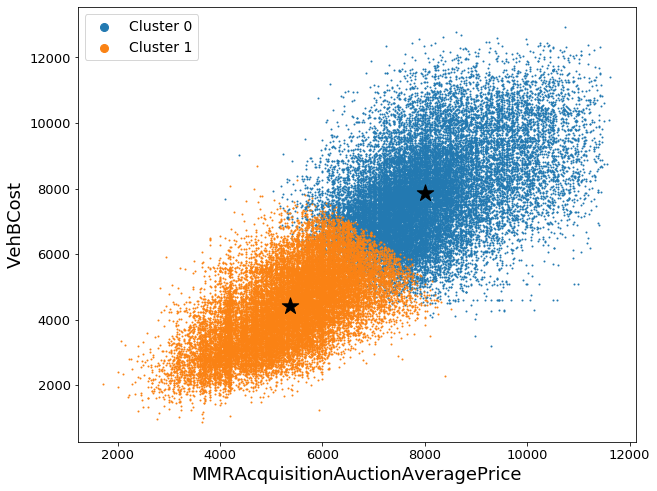

SSE 3485.8707303109154
Silhouette 0.33930805006095766


In [58]:
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, n_init=500, max_iter=500)
kmeans.fit(X)
centers = scaler.inverse_transform(kmeans.cluster_centers_)

LABEL_COLOR_MAP = {0 : '#2379b1',
                   1 : '#fa8214',
                   2 : '#2b9f2b',
                   3 : '#d32728',
                   4 : '#9366bc',
                   5 : '#8b5649',
                   6 : '#e277c2',
                   7 : '#7f7f7f',
                   8 : '#babd21',
                   9 : '#1dbbcd'
                   }

# Nice Pythonic way to get the indices of the points for each corresponding cluster
kmean_clusters = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

plt.figure(figsize=(10, 8))
for i in kmean_clusters.keys():
    plt.scatter(df.iloc[kmean_clusters[i]]['VehBCost'], df.iloc[kmean_clusters[i]]['MMRAcquisitionAuctionAveragePrice'], c=LABEL_COLOR_MAP[i], s=1, label='Cluster %s' % i)
plt.scatter(centers[:, 0], centers[:, 2], s=300, marker='*', c='k')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylabel('VehBCost', fontsize=18)
plt.xlabel('MMRAcquisitionAuctionAveragePrice', fontsize=18)
plt.legend(loc="upper left", fontsize = 14, markerscale = 8)
plt.show()

print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % silhouette_score(X, kmeans.labels_))

# k = 3

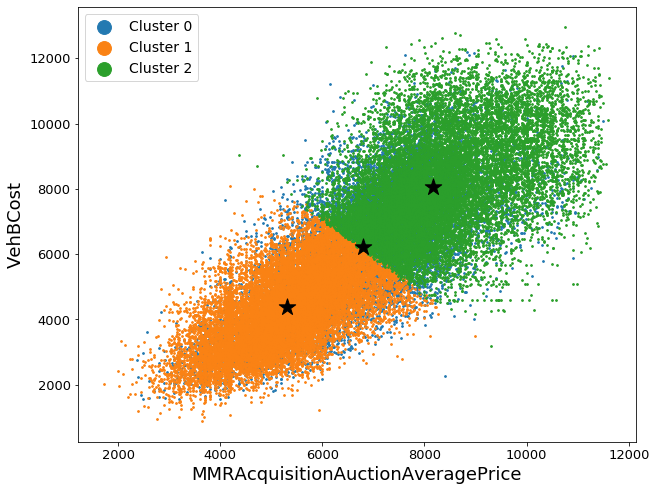

SSE 2378.6696074944734
Silhouette 0.35610752085181674


In [59]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, n_init=500, max_iter=100)
kmeans.fit(X)
centers = scaler.inverse_transform(kmeans.cluster_centers_)

LABEL_COLOR_MAP = {0 : '#2379b1',
                   1 : '#fa8214',
                   2 : '#2b9f2b',
                   3 : '#d32728',
                   4 : '#9366bc',
                   5 : '#8b5649',
                   6 : '#e277c2',
                   7 : '#7f7f7f',
                   8 : '#babd21',
                   9 : '#1dbbcd'
                   }

# Nice Pythonic way to get the indices of the points for each corresponding cluster
kmean_clusters = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

plt.figure(figsize=(10, 8))
for i in kmean_clusters.keys():
    plt.scatter(df.iloc[kmean_clusters[i]]['VehBCost'], df.iloc[kmean_clusters[i]]['MMRAcquisitionAuctionAveragePrice'], c=LABEL_COLOR_MAP[i], s=3, label='Cluster %s' % i)
plt.scatter(centers[:, 0], centers[:, 2], s=300, marker='*', c='k')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylabel('VehBCost', fontsize=18)
plt.xlabel('MMRAcquisitionAuctionAveragePrice', fontsize=18)
plt.legend(loc="upper left", fontsize = 14, markerscale = 8)
plt.show()

print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % silhouette_score(X, kmeans.labels_))

# k = 4

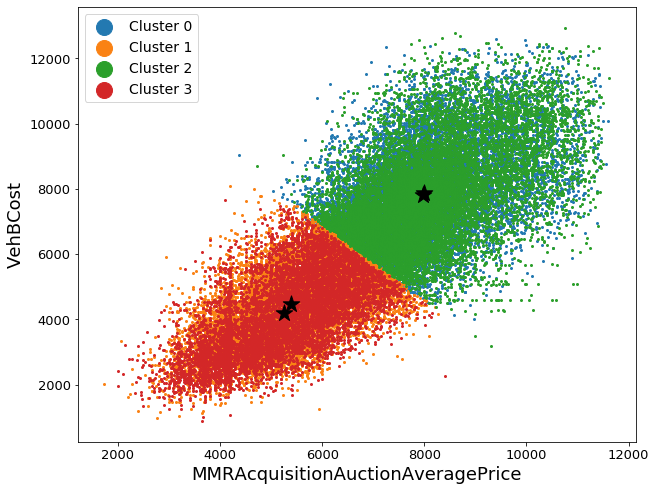

SSE 1873.7166365246587
Silhouette 0.3298606174646405


In [60]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, n_init=10, max_iter=500)
kmeans.fit(X)
centers = scaler.inverse_transform(kmeans.cluster_centers_)

LABEL_COLOR_MAP = {0 : '#2379b1',
                   1 : '#fa8214',
                   2 : '#2b9f2b',
                   3 : '#d32728',
                   4 : '#9366bc',
                   5 : '#8b5649',
                   6 : '#e277c2',
                   7 : '#7f7f7f',
                   8 : '#babd21',
                   9 : '#1dbbcd'
                   }

# Nice Pythonic way to get the indices of the points for each corresponding cluster
kmean_clusters = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

plt.figure(figsize=(10, 8))
for i in kmean_clusters.keys():
    plt.scatter(df.iloc[kmean_clusters[i]]['VehBCost'], df.iloc[kmean_clusters[i]]['MMRAcquisitionAuctionAveragePrice'], c=LABEL_COLOR_MAP[i], s=4, label='Cluster %s' % i)
plt.scatter(centers[:, 0], centers[:, 2], s=300, marker='*', c='k')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylabel('VehBCost', fontsize=18)
plt.xlabel('MMRAcquisitionAuctionAveragePrice', fontsize=18)
plt.legend(loc="upper left", fontsize = 14, markerscale = 8)
plt.show()

print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % silhouette_score(X, kmeans.labels_))

# k = 5

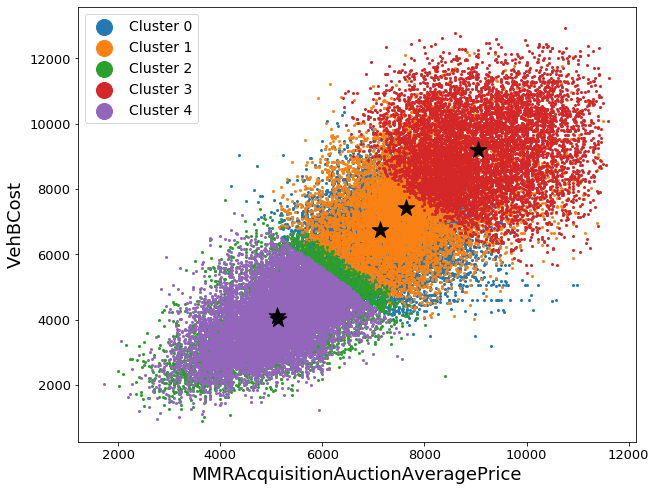

SSE 1555.7775628741952
Silhouette 0.31261323478024355


In [62]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, n_init=500, max_iter=500)
kmeans.fit(X)
centers = scaler.inverse_transform(kmeans.cluster_centers_)

LABEL_COLOR_MAP = {0 : '#2379b1',
                   1 : '#fa8214',
                   2 : '#2b9f2b',
                   3 : '#d32728',
                   4 : '#9366bc',
                   5 : '#8b5649',
                   6 : '#e277c2',
                   7 : '#7f7f7f',
                   8 : '#babd21',
                   9 : '#1dbbcd'
                   }

# Nice Pythonic way to get the indices of the points for each corresponding cluster
kmean_clusters = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

plt.figure(figsize=(10, 8))
for i in kmean_clusters.keys():
    plt.scatter(df.iloc[kmean_clusters[i]]['VehBCost'], df.iloc[kmean_clusters[i]]['MMRAcquisitionAuctionAveragePrice'], c=LABEL_COLOR_MAP[i], s=4, label='Cluster %s' % i)
plt.scatter(centers[:, 0], centers[:, 2], s=300, marker='*', c='k')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylabel('VehBCost', fontsize=18)
plt.xlabel('MMRAcquisitionAuctionAveragePrice', fontsize=18)
plt.legend(loc="upper left", fontsize = 14, markerscale = 8)
plt.show()

print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % silhouette_score(X, kmeans.labels_))